## Assignment 11.2
### Exercises 13 - 1

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import nsfg
import thinkstats2
import thinkplot
import survival

In [2]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

## Exercise 13-1

*In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.*

*Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.*

*Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.*

*Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.*

In [3]:
# data
resp6 = survival.ReadFemResp2002()
print(f"Resp 2002: {resp6.head()}")

resp7 = survival.ReadFemResp2010()
print(f"\nResp 2010: {resp7.head()}")

Resp 2002:    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity     finalwgt  \
0    2298      902     False       NaN        NaN       4  5556.717241   
1    5012      718      True     974.0     1077.0       1  4744.191350   
2   11586      708      True     910.0      938.0       1  4744.191350   
3    6794     1042     False       NaN        NaN       0  5923.977368   
4     616      991     False       NaN        NaN       0  7229.128072   

   cmintvw   agemarry        age  year  decade  fives  
0     1234        NaN  27.666667    75       7     15  
1     1233  21.333333  42.916667    59       5     11  
2     1234  16.833333  43.833333    58       5     11  
3     1234        NaN  16.000000    86       8     17  
4     1233        NaN  20.166667    82       8     16  

Resp 2010:    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity      wgtq1q16  \
0   34156      799     False       NaN        NaN       0   2571.376599   
1   40081      925      True    1314.0        

In [4]:
def CleanData(resp):
    """
    Cleans respondent data.

    args:
        resp: DataFrame
    """
    # replace invalid values with nan
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    # create new variables
    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    # create decade of age
    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [5]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [6]:
def ResampleDivorceCurve(resps):
    """
    Plots divorce curves based on resampled data.

    args:
        resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [7]:
def ResampleDivorceCurveByDecade(resps):
    """
    Plots divorce curves for each birth cohort.

    args:
        resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        
        groups = sample.groupby("decade")
        
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [8]:
def EstimateSurvival(resp):
    """
    Estimates the survival curve.

    args:
        resp: DataFrame of respondents

    returns: 
        pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [9]:
def EstimateSurvivalByDecade(groups, **options):
    """
    Groups respondents by decade and plots survival curves.

    args:
        groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

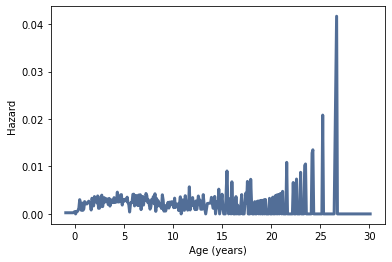

In [10]:
hf, sf = EstimateSurvival(resp6)

thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)', ylabel='Hazard')

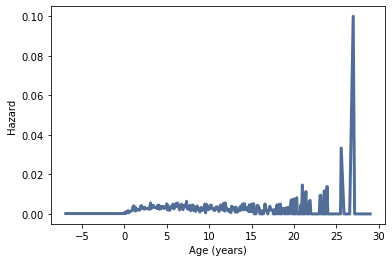

In [12]:
hf, sf = EstimateSurvival(resp7)

thinkplot.Plot(hf)
thinkplot.Config(xlabel='Age (years)', ylabel='Hazard')

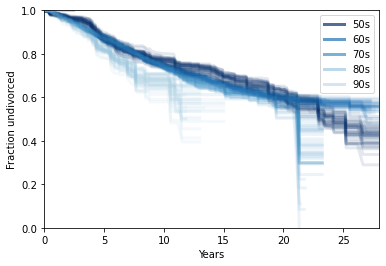

In [11]:
ResampleDivorceCurveByDecade([married6, married7])